# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/ECE_661/661_Final_Project')

In [ ]:
# import necessary dependencies
import argparse
import os
import time
import tools
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [ ]:
# define the ResBlock to be used in ResNet;
class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, k_size=3, stride_bool=False):
        super(ResBlock, self).__init__()
        if(stride_bool == True):
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, stride=2, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
        else:
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1)

        if input_dim != output_dim:
          input_dim = output_dim
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        y = x
      # Note shortcut will just be x if of same shape as out
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) 
        if (x.shape == out.shape):
          out = out + y
          out = F.relu(out)
          return out
        else:
          y = self.resconv(y)
          out = out.add(y)
          out = F.relu(out)
          return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    # 16 filter res blockss
    self.res1 = ResBlock(16, 16)
    self.res2 = ResBlock(16, 16)
    self.res3 = ResBlock(16, 16)
    # Now 32 filter res blocks
    self.res4 = ResBlock(16, 32, stride_bool=True)
    self.res5 = ResBlock(32, 32)
    self.res6 = ResBlock(32, 32)
    # Now 64 filter res blocks 
    self.res7 = ResBlock(32, 64, stride_bool=True)
    self.res8 = ResBlock(64, 64)
    self.res9 = ResBlock(64, 64)

    self.fc = nn.Linear(64, 10)
    self.fc2 = nn.Linear(64,4)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))

    # ReLU contained within forward method of res blocks
    
    out = self.res1(out)
    out = self.res2(out)
    out = self.res3(out)

    out = self.res4(out)
    out = self.res5(out)
    out = self.res6(out)

    out = self.res7(out)
    out = self.res8(out)
    out = self.res9(out)

    out = F.adaptive_avg_pool2d(out, 1)
    out = out.view(out.size(0), -1)
    outt = self.fc(out)
    outr = self.fc2(out)
    # out = F.softmax(out)
    return outt, outr


class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride = 1, padding = 1) # I am not sure about this output, should it be 32 or 3? Also coudln't I just use identities by forcing 
        self.conv1_bn = nn.BatchNorm2d(16)

        #starting first section of 6 - feature map 32, channel (features) 16
        self.conv2 = nn.Conv2d(16,16,3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,16,3, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16,16,3, padding = 1)
        self.conv4_bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16,16,3, padding = 1)
        self.conv5_bn = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16,16,3, padding = 1)
        self.conv6_bn = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16,16,3, padding = 1) #it would be here that I need a 1x1 convolution on my bypass that gets fed to lower stuff 
        self.conv7_bn = nn.BatchNorm2d(16)
        self.bp4_conv = nn.Conv2d(16,32,1, stride = 2)
        self.bp4_bn = nn.BatchNorm2d(32) 

        

        #Now starting second section of 6 - now feature map 16, channel (features) 32
        self.conv8 = nn.Conv2d(16,32,3, stride = 2, padding = 1) # HERE COULD BE AN ISSUE - I AM NOT SURE IF I SHOULD PAD OR NOT 
        self.conv8_bn = nn.BatchNorm2d(32) 
        self.conv9 = nn.Conv2d(32,32,3, padding = 1)
        self.conv9_bn = nn.BatchNorm2d(32) 
        self.conv10 = nn.Conv2d(32,32,3, padding = 1)
        self.conv10_bn = nn.BatchNorm2d(32) 
        self.conv11 = nn.Conv2d(32,32,3, padding = 1)
        self.conv11_bn = nn.BatchNorm2d(32) 
        self.conv12 = nn.Conv2d(32,32,3, padding = 1)
        self.conv12_bn = nn.BatchNorm2d(32) 
        self.conv13 = nn.Conv2d(32,32,3, padding = 1) # need 1x1 conv here on bypass that gets fed to lower stuff 
        self.conv13_bn = nn.BatchNorm2d(32)
        self.bp7_conv = nn.Conv2d(32,64,1, stride = 2)
        self.bp7_bn = nn.BatchNorm2d(64) 

        # now starting third section of 6 - feature map is 8, channel (features) 64 (8x8x64)
        self.conv14 = nn.Conv2d(32,64,3, stride = 2, padding = 1) # SAME THING MAYBE I NEED TO PADD MAYBE I DON'T NEED TO 
        self.conv14_bn = nn.BatchNorm2d(64) 
        self.conv15 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv15_bn = nn.BatchNorm2d(64) 
        self.conv16 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv16_bn = nn.BatchNorm2d(64) 
        self.conv17 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv17_bn = nn.BatchNorm2d(64) 
        self.conv18 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv18_bn = nn.BatchNorm2d(64) 
        self.conv19 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv19_bn = nn.BatchNorm2d(64)  
       

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1   = nn.Linear(64,10)
        self.fc2 = nn.Linear(64,4) 

    # THIS IS WHERE I need to fit it all together and worry about my residual stuff 
    def forward(self, x):
        out = F.relu(self.conv1_bn(self.conv1(x))) # this is okay, goes after conv and before activation functionp

        bp1 = out # SAVE THE BYPASS DATA HERE, MAYBE COPY? Maybe not 
      
        out = F.relu(self.conv2_bn(self.conv2(out)))

        out = self.conv3_bn(self.conv3(out))
  
        # IN here I need to add the first bypass data to the current out, then I feed it to the next guy - need to think a little about when I need to do the convolution on the BP
        out = bp1 + out #This totally works! Very chill and cool of pytorch lol
        out = F.relu(out)
        bp2 = out # maybe copy, maybe not, we'll see 
        out  = F.relu(self.conv4_bn(self.conv4(out)))
        out = self.conv5_bn(self.conv5(out))
        out = bp2 + out
        out = F.relu(out)
        bp3 = out
        out = F.relu(self.conv6_bn(self.conv6(out)))
        out = self.conv7_bn(self.conv7(out))
        out = out + bp3
        out = F.relu(out)
        bp4 = out
        bp4_ready = self.bp4_bn(self.bp4_conv(bp4))
        out = F.relu(self.conv8_bn(self.conv8(out)))
        out = self.conv9_bn(self.conv9(out))
        out = bp4_ready+out
        out = F.relu(out)
        bp5 = out
        out = F.relu(self.conv10_bn(self.conv10(out)))
        out = self.conv11_bn(self.conv11(out))
        out = out + bp5
        out = F.relu(out)
        bp6 = out
        out = F.relu(self.conv12_bn(self.conv12(out)))
        out = self.conv13_bn(self.conv13(out))
        out = out + bp6
        out = F.relu(out)
        bp7 = out
        bp7_ready = self.bp7_bn(self.bp7_conv(out))
        out = F.relu(self.conv14_bn(self.conv14(out)))
        out = self.conv15_bn(self.conv15(out))
        out = bp7_ready+out
        out = F.relu(out)
        bp8 = out
        out = F.relu(self.conv16_bn(self.conv16(out)))
        out = self.conv17_bn(self.conv17(out))
        out = out + bp8
        out = F.relu(out)
        bp9 = out
        out = F.relu(self.conv18_bn(self.conv18(out)))
        out = self.conv19_bn(self.conv19(out))
        out = out + bp9
        out = F.relu(out)
        out = self.avg_pool(out)


        out = out.view(out.size(0), -1) # IF THIS BREAKS THEN CHECK HERE, Might need it might not
        #avg pooling here
        #fully connected here
        outt = self.fc1(out)
        outr = self.fc2(out)
        return outt, outr

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                      transforms.RandomCrop(size=(32,32), padding=4),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(degrees=15)]) 
                                      # transforms.GaussianBlur(kernel_size=5, sigma = 0.5)])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [ ]:
# do NOT change these
#import tools
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=256,  # your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_labels = np.asarray(np.load('/content/drive/MyDrive/ECE_661/661_Final_Project/tools/test-labels-batch.npy'))

In [ ]:
import shutil
from PIL import Image
from torch.utils.data import Dataset as VisionDataset
from tools.utils import check_integrity, download_and_extract_archive
import torchvision
import torchvision.transforms as transforms

# #import tools
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    download=True,
    transform=transform_val
)


test_loader = DataLoader(
    test_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_test_F22.zip
Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [ ]:
# specify the device for computation
#############################################
# your code here
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
  
    
#############################################

Run on GPU...


In [ ]:
!nvidia-smi

Wed Dec 14 22:52:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

net = ResNet().to(device)
# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
#############################################

## Step 5: Setup attack (all cool like)

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


## Only data augmentation - bo below is the attacks 


In [ ]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)[0]
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

def test_net(net, dataloader, batch_size):
  correct = 0
  total = 10000
  size_total = 0
  i = 0
  for x in dataloader:
    x = x.to(device)
    out = net(x)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total    

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def random_noise_attack(model, device, dat, eps):
    # Add uniform random noise in [-eps,+eps]
    x_adv = dat.clone().detach() + torch.FloatTensor(dat.shape).uniform_(-eps, eps).to(device)
    # Clip the perturbed datapoints to ensure we are in bounds [0,1]
    x_adv = torch.clamp(x_adv.clone().detach(), 0., 1.)
    # Return perturbed samples
    return x_adv

# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model,device,data,lbl):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out[0],lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()


def PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start):
    # TODO: Implement the PGD attack
    # - dat and lbl are tensors
    # - eps and alpha are floats
    # - iters is an integer
    # - rand_start is a bool

    # x_nat is the natural (clean) data batch, we .clone().detach()
    # to copy it and detach it from our computational graph
    x_nat = dat.clone().detach()

    # If rand_start is True, add uniform noise to the sample within [-eps,+eps],
    # else just copy x_nat
    if alpha == 0:
      return x_nat
    # if rand_start == True:
        # x_perturb = random_noise_attack(model, device, x_nat, eps)

    # else:
      #  x_perturb = torch.clamp(x_nat, 0, 1)
       #print('is it true that I just clamp x_nat when rand_start is false?')
    
    x_perturb = x_nat.clone()


    # Make sure the sample is projected into original distribution bounds [0,1]
    
    for i in range(0,iters):

        # Compute gradient w.r.t. data (we give you this function, but understand it)
        gradient = gradient_wrt_data(model, device, x_perturb, lbl)
        # Perturb the image using the gradient
        
        # Clip the perturbed datapoints to ensure we still satisfy L_infinity constraint
        x_perturb = torch.clamp(torch.add(x_perturb, torch.mul(alpha,torch.sign(gradient))), torch.sub(x_nat, eps), torch.add(x_nat, eps))
        # x_perturb = torch.clamp(x_perturb, torch.sub(x_nat, eps), torch.add(x_nat, eps))
        # Clip the perturbed datapoints to ensure we are in bounds [0,1]

        # x_perturb = torch.clamp(x_perturb, 0,1)

    # Return the final perturbed samples

    return x_perturb

def FGSM_attack(model, device, dat, lbl, eps):
    # TODO: Implement the FGSM attack
    # - Dat and lbl are tensors
    # - eps is a float

    # HINT: FGSM is a special case of PGD

    #print('for FGSM, just doing PGD with some different parameters, ask about clipping or not?')
    return PGD_attack(model, device, dat, lbl, eps, alpha = eps, iters = 1, rand_start = False)



Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0; Whitebox Accuracy: 0.9088;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6982;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.02; Whitebox Accuracy: 0.498;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.03; Whitebox Accuracy: 0.3744;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.04; Whitebox Accuracy: 0.2994;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.05; Whitebox Accuracy: 0.2582;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.06; Whitebox Accuracy: 0.2342;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.07; Whitebox Accuracy: 0.2148;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.08; Whitebox Accuracy: 0.2052;
Done!
Initial Accuracy of Whitebox Model:  0.9088
Attack Epsilon: 0.09; Whitebox Accuracy: 0.1976;
Done!
Initial Accura

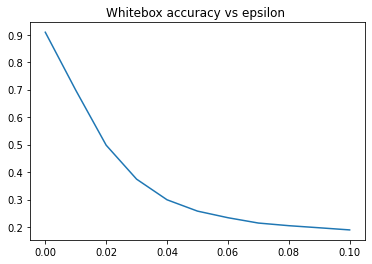

In [ ]:
## Load pretrained models

import matplotlib.pyplot as plt
import random

x_s= []
a_base = []


## Note that whitebox is currently our base, others named better##
for ATK_EPS in [0, .01,.02,.03,.04,.05,.06,.07,.08,.09,.1]:
  whitebox = ResNet().to(device) #if breaks remove the .to(device)



  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(whitebox.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
  #############################################
  state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_base.pth")
  whitebox.load_state_dict(state_dict["state_dict"])
  
  x_s.append(ATK_EPS)
 
  whitebox.eval(); 

  test_acc,_ = test_model(whitebox,val_loader,device) # THIS NEEDS TO BE CHANGED TO TESTING DATA
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  
  whitebox.eval()
  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 1
  ATK_ALPHA = 1

  whitebox_correct = 0.
  cut_correct = 0.
  running_total = 0.
  i = 0 
  batch_size = 256
  for batch_idx,(data,labels) in enumerate(val_loader):
      data = data.to(device) 
      labels = labels.to(device)

      # TODO: Perform adversarial attack here
      adv_data = FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # TODO: Perform adversarial attack here

      # adv_data = random_noise_attack(whitebox, device, data, ATK_EPS)
      # adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # inds = random.sample(list(range(data.size(0))),6)
      # plt.figure(figsize=(15,5))
      # for jj in range(1):
      #     plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
      # for jj in range(1):
      #     plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
      # plt.tight_layout()
      # plt.show()

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      # assert(adv_data.max() == 1.)
      # assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)[0]
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()

          
      
          running_total += labels.size(0)
      
      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final 
  whitebox_acc = whitebox_correct/running_total
 
  a_base.append(whitebox_acc)
  
  

  print("Attack Epsilon: {}; Whitebox Accuracy: {};".format(ATK_EPS, whitebox_acc))

  print("Done!")



plt.figure()
plt.title('Whitebox accuracy vs epsilon ')
plt.plot([x for x in x_s], a_base)




Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0; Whitebox Accuracy: 0.9131;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6807;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.02; Whitebox Accuracy: 0.4973;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.03; Whitebox Accuracy: 0.3774;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.04; Whitebox Accuracy: 0.3077;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.05; Whitebox Accuracy: 0.2669;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.06; Whitebox Accuracy: 0.242;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.07; Whitebox Accuracy: 0.2221;
Done!
Initial Accuracy of Whitebox Model:  0.913100004196167
Attack Epsilon: 0.08; Whitebox Accuracy: 0.2087;
Done!
Initial Accura

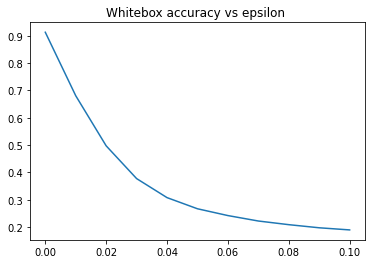

In [ ]:
## Load pretrained models

import matplotlib.pyplot as plt
import random

x_s= []
a_cut = []


## Note that whitebox is currently our base, others named better##
for ATK_EPS in [0, .01,.02,.03,.04,.05,.06,.07,.08,.09,.1]:
  whitebox = ResNet().to(device) #if breaks remove the .to(device)



  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(whitebox.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
  #############################################
  state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_cutout.pth")
  whitebox.load_state_dict(state_dict["state_dict"])
  
  x_s.append(ATK_EPS)
 
  whitebox.eval(); 

  test_acc = test_net(whitebox,test_loader,256).item() # THIS NEEDS TO BE CHANGED TO TESTING DATA
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  
  whitebox.eval()
  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 1
  ATK_ALPHA = 1

  whitebox_correct = 0.
  cut_correct = 0.
  running_total = 0.
  i = 0 
  batch_size = 256
  for batch_idx, (data) in enumerate(test_loader):
      labels = torch.Tensor(test_labels[i:i+batch_size]).long().to(device) 
      data = data.to(device) 
      i+=batch_size

      # TODO: Perform adversarial attack here
      adv_data = FGSM_attack(whitebox, device, data, labels, ATK_EPS)
      # adv_data = random_noise_attack(whitebox, device, data, ATK_EPS)
      # adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # inds = random.sample(list(range(data.size(0))),6)
      # plt.figure(figsize=(15,5))
      # for jj in range(1):
      #     plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
      # for jj in range(1):
      #     plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
      # plt.tight_layout()
      # plt.show()

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      # assert(adv_data.max() == 1.)
      # assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)[0]
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()

          
      
          running_total += labels.size(0)
      
      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final 
  whitebox_acc = whitebox_correct/running_total
 
  a_cut.append(whitebox_acc)
  
  

  print("Attack Epsilon: {}; Whitebox Accuracy: {};".format(ATK_EPS, whitebox_acc))

  print("Done!")



plt.figure()
plt.title('Whitebox accuracy vs epsilon ')
plt.plot([x for x in x_s], a_cut)



Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0; Whitebox Accuracy: 0.9056;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.01; Whitebox Accuracy: 0.7215;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5899;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.03; Whitebox Accuracy: 0.5229;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.04; Whitebox Accuracy: 0.483;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.05; Whitebox Accuracy: 0.4583;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.06; Whitebox Accuracy: 0.4406;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.07; Whitebox Accuracy: 0.4286;
Done!
Initial Accuracy of Whitebox Model:  0.9055999517440796
Attack Epsilon: 0.08; Whitebox Accuracy: 0.4173;
Done!
Initi

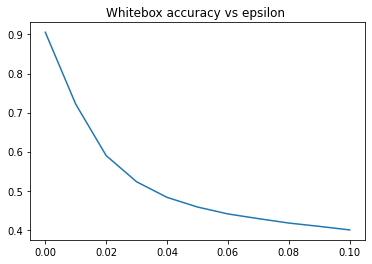

In [ ]:
## Load pretrained models

import matplotlib.pyplot as plt
import random

x_s= []
a_mix = []


## Note that whitebox is currently our base, others named better##
for ATK_EPS in [0, .01,.02,.03,.04,.05,.06,.07,.08,.09,.1]:
  whitebox = ResNet().to(device) #if breaks remove the .to(device)



  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(whitebox.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
  #############################################
  state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_mixup.pth")
  whitebox.load_state_dict(state_dict["state_dict"])
  
  x_s.append(ATK_EPS)
 
  whitebox.eval(); 

  test_acc = test_net(whitebox,test_loader,256).item() # THIS NEEDS TO BE CHANGED TO TESTING DATA
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  
  whitebox.eval()
  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 1
  ATK_ALPHA = 1

  whitebox_correct = 0.
  cut_correct = 0.
  running_total = 0.
  i = 0 
  batch_size = 256
  for batch_idx, (data) in enumerate(test_loader):
      labels = torch.Tensor(test_labels[i:i+batch_size]).long().to(device) 
      data = data.to(device) 
      i+=batch_size

      # TODO: Perform adversarial attack here
      adv_data = FGSM_attack(whitebox, device, data, labels, ATK_EPS)
      # adv_data = random_noise_attack(whitebox, device, data, ATK_EPS)
      # adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # inds = random.sample(list(range(data.size(0))),6)
      # plt.figure(figsize=(15,5))
      # for jj in range(1):
      #     plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
      # for jj in range(1):
      #     plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
      # plt.tight_layout()
      # plt.show()

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      # assert(adv_data.max() == 1.)
      # assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)[0]
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()

          
      
          running_total += labels.size(0)
      
      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final 
  whitebox_acc = whitebox_correct/running_total
 
  a_mix.append(whitebox_acc)
  
  

  print("Attack Epsilon: {}; Whitebox Accuracy: {};".format(ATK_EPS, whitebox_acc))

  print("Done!")



plt.figure()
plt.title('Whitebox accuracy vs epsilon ')
plt.plot([x for x in x_s], a_mix)

Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0; Whitebox Accuracy: 0.8915;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6927;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5424;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.03; Whitebox Accuracy: 0.4667;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4169;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.05; Whitebox Accuracy: 0.388;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.06; Whitebox Accuracy: 0.37;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.07; Whitebox Accuracy: 0.3552;
Done!
Initial Accuracy of Whitebox Model:  0.8914999961853027
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3454;
Done!
Initial

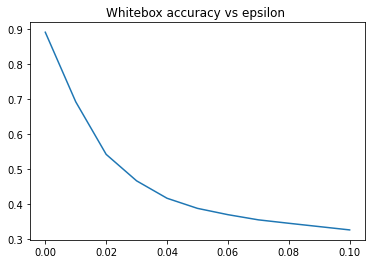

In [ ]:
## Load pretrained models

import matplotlib.pyplot as plt
import random

x_s= []
a_mix_cut = []


## Note that whitebox is currently our base, others named better##
for ATK_EPS in [0, .01,.02,.03,.04,.05,.06,.07,.08,.09,.1]:
  whitebox = ResNet().to(device) #if breaks remove the .to(device)



  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(whitebox.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
  #############################################
  state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_mixup_cutout.pth")
  whitebox.load_state_dict(state_dict["state_dict"])
  
  x_s.append(ATK_EPS)
 
  whitebox.eval(); 

  test_acc = test_net(whitebox,test_loader,256).item() # THIS NEEDS TO BE CHANGED TO TESTING DATA
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  
  whitebox.eval()
  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 1
  ATK_ALPHA = 1

  whitebox_correct = 0.
  cut_correct = 0.
  running_total = 0.
  i = 0 
  batch_size = 256
  for batch_idx, (data) in enumerate(test_loader):
      labels = torch.Tensor(test_labels[i:i+batch_size]).long().to(device) 
      data = data.to(device) 
      i+=batch_size

      # TODO: Perform adversarial attack here
      adv_data = FGSM_attack(whitebox, device, data, labels, ATK_EPS)
      # adv_data = random_noise_attack(whitebox, device, data, ATK_EPS)
      # adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # inds = random.sample(list(range(data.size(0))),6)
      # plt.figure(figsize=(15,5))
      # for jj in range(1):
      #     plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
      # for jj in range(1):
      #     plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
      # plt.tight_layout()
      # plt.show()

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      # assert(adv_data.max() == 1.)
      # assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)[0]
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()

          
      
          running_total += labels.size(0)
      
      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final 
  whitebox_acc = whitebox_correct/running_total
 
  a_mix_cut.append(whitebox_acc)
  
  

  print("Attack Epsilon: {}; Whitebox Accuracy: {};".format(ATK_EPS, whitebox_acc))

  print("Done!")



plt.figure()
plt.title('Whitebox accuracy vs epsilon ')
plt.plot([x for x in x_s], a_mix_cut)

Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0; Whitebox Accuracy: 0.8094;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.01; Whitebox Accuracy: 0.5616;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.02; Whitebox Accuracy: 0.3775;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.03; Whitebox Accuracy: 0.2755;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.04; Whitebox Accuracy: 0.2072;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.05; Whitebox Accuracy: 0.1649;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.06; Whitebox Accuracy: 0.1388;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.07; Whitebox Accuracy: 0.1232;
Done!
Initial Accuracy of Whitebox Model:  0.8093999624252319
Attack Epsilon: 0.08; Whitebox Accuracy: 0.1109;
Done!
Init

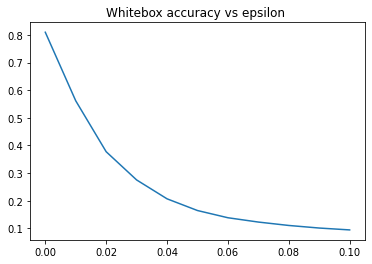

In [ ]:
## Load pretrained models

import matplotlib.pyplot as plt
import random

x_s= []
a_aux_cut = []


## Note that whitebox is currently our base, others named better##
for ATK_EPS in [0, .01,.02,.03,.04,.05,.06,.07,.08,.09,.1]:
  whitebox = ResNet().to(device) #if breaks remove the .to(device)



  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(whitebox.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
  #############################################
  state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_aux_cutout.pth")
  whitebox.load_state_dict(state_dict["state_dict"])
  
  x_s.append(ATK_EPS)
 
  whitebox.eval(); 

  test_acc = test_net(whitebox,test_loader,256).item() # THIS NEEDS TO BE CHANGED TO TESTING DATA
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  
  whitebox.eval()
  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 1
  ATK_ALPHA = 1

  whitebox_correct = 0.
  cut_correct = 0.
  running_total = 0.
  i = 0 
  batch_size = 256
  for batch_idx, (data) in enumerate(test_loader):
      labels = torch.Tensor(test_labels[i:i+batch_size]).long().to(device) 
      data = data.to(device) 
      i+=batch_size

      # TODO: Perform adversarial attack here
      adv_data = FGSM_attack(whitebox, device, data, labels, ATK_EPS)
      # adv_data = random_noise_attack(whitebox, device, data, ATK_EPS)
      # adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)

      # inds = random.sample(list(range(data.size(0))),6)
      # plt.figure(figsize=(15,5))
      # for jj in range(1):
      #     plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
      # for jj in range(1):
      #     plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
      #     # plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
      # plt.tight_layout()
      # plt.show()

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      # assert(adv_data.max() == 1.)
      # assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)[0]
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()

          
      
          running_total += labels.size(0)
      
      # Plot some samples
      # if batch_idx == 1:
      #     plt.figure(figsize=(15,5))
      #     for jj in range(12):
      #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
      #     plt.tight_layout()
      #     plt.show()

  # Print final 
  whitebox_acc = whitebox_correct/running_total
 
  a_aux_cut.append(whitebox_acc)
  
  

  print("Attack Epsilon: {}; Whitebox Accuracy: {};".format(ATK_EPS, whitebox_acc))

  print("Done!")



plt.figure()
plt.title('Whitebox accuracy vs epsilon ')
plt.plot([x for x in x_s], a_aux_cut)